24/07/2017 

A. Gentile

### testing the behaviour of QMD for 2qubit NV hyperfine coupling Hamiltonian term


## Library uploading

In [1]:
%matplotlib inline

import qinfer as qi
#import qutip as qt
import numpy as np
import scipy as sp
from IPython.display import display, Math, Latex
from functools import partial
import matplotlib.pyplot as plt
import importlib as imp

In [2]:
import datetime
import os as os
import time as time

In [3]:
import logging as logging
import sys

%run LoggingCode.py

In [4]:
# tell the user where files will be saved
dire = os.getcwd()
dire = dire+"/tests/"
dire = os.path.normpath(dire)
print('Files will be saved in:')
print(dire)

Files will be saved in:
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\tests


In [5]:
# Add personalized library to PYTHONPATH
sys.path.append(os.path.join("..","Libraries","QML_lib"))

In [6]:
from Norms import *
from IOfuncts import *
from EvalLoss import *

import ProbeStates as pros
import multiPGH as mpgh
import GenSimQMD as gsi
import Evo as evo
import Distrib as distr

In [7]:
import warnings as warnings

""" filter only the Weight Clipping warning """
#SET LEVEL WARNINGS TO 0 In FINAL VERSION
warnings.filterwarnings("ignore", message='Negative weights occured', category=RuntimeWarning)

## Reload when needed

In [7]:
imp.reload(pros)
imp.reload(mpgh)
imp.reload(gsi)
imp.reload(evo)
imp.reload(distr)

<module 'Distrib' from '..\\Libraries\\QML_lib\\Distrib.py'>

# Choose model & parameters & probe states

In [8]:
spinlst = [evo.sigmax(),evo.sigmay(), evo.sigmaz()]    

In [9]:
# Implement the NV centre spin- nuclear (iso)spin interaction term

oplist = np.array(list(map(lambda j: np.kron(spinlst[j],spinlst[j]), range(len(spinlst)))))
print('Oplist: ' + repr(oplist))

Oplist: array([[[ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j],
        [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j],
        [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
        [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j]],

       [[ 0.+0.j,  0.-0.j,  0.-0.j, -1.+0.j],
        [ 0.+0.j,  0.+0.j,  1.-0.j,  0.-0.j],
        [ 0.+0.j,  1.-0.j,  0.+0.j,  0.-0.j],
        [-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j]],

       [[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]]])


In [10]:
# True params are chosen according to Felton et al. PHYSICAL REVIEW B 79, 075203 2009

true_params = np.array([[0.27, 0.27, 0.214]])
print('Chosen true_params: ' + str(true_params))

# quick test of the getH function, OK!
(np.tensordot(true_params, oplist, axes=1))


Chosen true_params: [[ 0.27   0.27   0.214]]


array([[[ 0.214+0.j,  0.000+0.j,  0.000+0.j,  0.000+0.j],
        [ 0.000+0.j, -0.214+0.j,  0.540+0.j,  0.000+0.j],
        [ 0.000+0.j,  0.540+0.j, -0.214+0.j,  0.000+0.j],
        [ 0.000+0.j,  0.000+0.j,  0.000+0.j,  0.214+0.j]]])

In [11]:
#Probelist

probelist = list(map(lambda x: pros.def_randomprobe(oplist), range(20)))
#probelist = [pros.choose_probe(oplist)]
#print('Chosen probe: ', repr(probelist))

Adopted random sampling of $| \Psi_{probe} \rangle$ for both the $\hat{S}$ and $\hat{I}$ operators

# Results from QLE trivial step-by-step implementation

In [48]:
prior = distr.MultiVariateUniformDistribution(len(oplist), DistroLimits=np.array([[0.1,0.4]]))

# probelist can be either:
# - [probestate] : in this case the probe is constantly selected from the state provided
# - "eiglist" or "probelist": in this case, the probe is selected sequentially (eventually with some weighting) among the list provided

probecounter = 0
invertize=False
trotterize=False
model = gsi.GenSimQMD(oplist=oplist, modelparams=true_params, probecounter = probecounter,  
                      true_oplist = oplist, trueparams=true_params,
                      probelist=probelist, 
                      trotter = trotterize, IQLE=invertize)

n_particles = 200
n_experiments = 150

# higher resample_threshold -> higher frequency of resampling
# higher a in LiuWest -> less "data scrambling", slower learning
updater = qi.SMCUpdater(model, n_particles, prior, resample_thresh=0.6, resampler = qi.LiuWestResampler(a=0.8), debug_resampling=True)

#IQLE already works well with resample_thresh=0.5, resampler = qi.LiuWestResampler(a=0.8)

inv_field = [item[0] for item in model.expparams_dtype[1:] ]
print('Inversion fields are: ' + str(inv_field))
heuristic = mpgh.multiPGH(updater, oplist, inv_field=inv_field)
experiment = heuristic()
print('Heuristic output:' + repr(experiment))

expparams = np.empty((1, ), dtype=model.expparams_dtype)

print('Initialization Ready')

Inversion fields are: ['w_1', 'w_2', 'w_3']
Heuristic output:array([ (2.2001814670962787, 0.3270848428464246, 0.20102712189096475, 0.39433322217586275)], 
      dtype=[('t', '<f8'), ('w_1', '<f8'), ('w_2', '<f8'), ('w_3', '<f8')])
Initialization Ready


In [49]:
datum = model.simulate_experiment(true_params, experiment)
print(repr(datum))

0


In [50]:
updater.update(datum, experiment)

In [51]:
start = time.clock()

# probecounter for the choice of the state
probecounter = 0

track_loss = np.empty(n_experiments)
track_cov = np.empty(n_experiments)
track_time = np.empty(n_experiments)

track_particle_locs = np.empty([n_particles, len(true_params[0]), n_experiments])
track_particle_wght = np.empty([n_particles, n_experiments])


for idx_experiment in range(n_experiments):
    
    experiment = heuristic()
    #print('Chosen experiment: ' + repr(experiment))
    
    if idx_experiment == 0:
        print('Initial time selected > ' + str(experiment[0][0]))
    if idx_experiment == n_experiments-1:
        print('Final time selected > ' + str(experiment[0][0]))
    
    track_time[idx_experiment] = experiment[0][0]
    
    datum = model.simulate_experiment(true_params, experiment)
    #print(repr(datum))
    updater.update(datum, experiment)
#     heuristic = mpgh.multiPGH(updater, oplist, inv_field=inv_field)
    
    track_cov[idx_experiment] = np.linalg.norm(updater.est_covariance_mtx())
    
    track_particle_locs[:, :, idx_experiment] = updater.particle_locations
    track_particle_wght[:, idx_experiment] = updater.particle_weights

    new_eval = updater.est_mean()
    
    new_loss = eval_loss(model, new_eval, true_params)
    track_loss[idx_experiment] = new_loss[0]
    
end = time.clock()

print("\n\nElapsed time:" + str(end-start) + " secs")

Initial time selected > 20.4920008082


qinfer.smc - DEBUG - Resampling changed mean by [ 0.00317549 -0.00739619  0.00813347]. Norm change in cov: 0.001457594890075302.
qinfer.smc - DEBUG - Resampling changed mean by [-0.00045572 -0.00206146  0.00574166]. Norm change in cov: 0.000941280084302511.
qinfer.smc - DEBUG - Resampling changed mean by [ 0.00529601  0.00057635  0.00157763]. Norm change in cov: 0.0011633190357331956.
qinfer.smc - DEBUG - Resampling changed mean by [-0.00115607  0.00072234 -0.00142568]. Norm change in cov: 0.000970467307134262.
qinfer.smc - DEBUG - Resampling changed mean by [ 0.00167737  0.00150589 -0.00221454]. Norm change in cov: 0.0006282992728954104.
qinfer.smc - DEBUG - Resampling changed mean by [ 0.00039456 -0.00043209 -0.00272912]. Norm change in cov: 0.0006147775501042188.
qinfer.smc - DEBUG - Resampling changed mean by [ 0.00128247 -0.00232079 -0.00126619]. Norm change in cov: 0.0008304979164045558.
qinfer.smc - DEBUG - Resampling changed mean by [-0.00284075 -0.00208203 -0.00483036]. Norm c

Final time selected > 8.66641898984


Elapsed time:17.115549252243056 secs


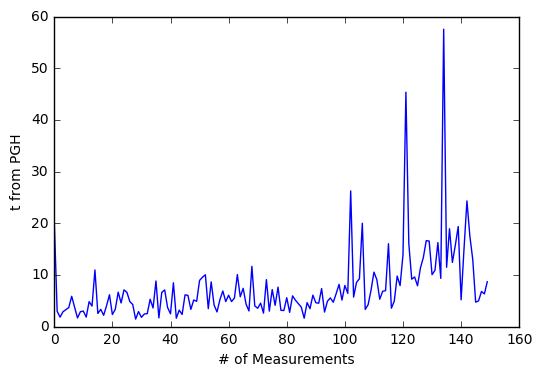

In [52]:
plt.plot(track_time)
plt.xlabel('# of Measurements')
plt.ylabel('t from PGH')

plt.show()

## use this only if real and simulated models coincide

C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\tests_QLE_Trotter-False_2qubits(Hf_I-0.5)_Nparts_200____2017-07-26_18.22.28.pdf


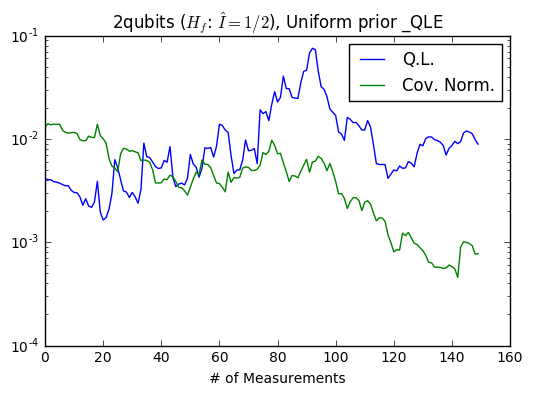

In [53]:
timestamp = str(datetime.datetime.now()).split('.')[0]
timestamp = "_"+timestamp.replace(" ", "_")
timestamp = timestamp.replace(":", ".")

labelize = '_IQLE' if invertize == True else '_QLE'

plt.semilogy(track_loss, label='Q.L.')
plt.semilogy(track_cov, label='Cov. Norm.')
plt.legend()
plt.xlabel('# of Measurements')
plt.title(r"2qubits ($H_f$: $\hat{I}=1/2$), Uniform prior "+ labelize)


filefigname = dire+labelize+"_Trotter-"+str(trotterize)+"_2qubits(Hf_I-0.5)"+"_Nparts_"+str(n_particles)+"___"+str(timestamp)+".pdf"
filefigname = os.path.normpath(filefigname)
print(filefigname)
plt.savefig(filefigname)


plt.show()

# Multiple tests for IQLE

In [151]:
prior = distr.MultiVariateUniformDistribution(len(oplist), DistroLimits=np.array([[0.1,0.4]]))

# probelist can be either:
# - [probestate] : in this case the probe is constantly selected from the state provided
# - "eiglist" or "probelist": in this case, the probe is selected sequentially (eventually with some weighting) among the list provided

probecounter = 0
invertize=True
trotterize=True
model = gsi.GenSimQMD(oplist=oplist, modelparams=true_params, probecounter = probecounter,  
                      true_oplist = oplist, trueparams=true_params,
                      probelist=probelist, 
                      trotter = trotterize, IQLE=invertize)

n_particles = 150
n_experiments = 150

# higher resample_threshold -> higher frequency of resampling
# higher a in LiuWest -> less "data scrambling", slower learning

resamp_t = 0.85
resamp_a = 0.7
extra_updater_args={'resample_thresh': 0.7, 'resampler': qi.LiuWestResampler(a=0.8), 'debug_resampling': False}
updater = qi.SMCUpdater(model, n_particles, prior, **extra_updater_args)


#IQLE already works well with resample_thresh=0.5, resampler = qi.LiuWestResampler(a=0.8)

inv_field = [item[0] for item in model.expparams_dtype[1:] ]
print('Inversion fields are: ' + str(inv_field))
heuristic = mpgh.multiPGH(updater, oplist, inv_field=inv_field)
experiment = heuristic()
print('Heuristic output:' + repr(experiment))

expparams = np.empty((1, ), dtype=model.expparams_dtype)

print('Initialization Ready')

Inversion fields are: ['w_1', 'w_2', 'w_3']
Heuristic output:array([ (1.8079126203198492, 0.3876200482869998, 0.18984941416954615, 0.29942821834231603)], 
      dtype=[('t', '<f8'), ('w_1', '<f8'), ('w_2', '<f8'), ('w_3', '<f8')])
Initialization Ready


In [152]:
n_trials =2

start = time.clock()

# probecounter for the choice of the state
probecounter = 0
track_loss = np.empty([n_trials, n_experiments])

for trial in range(n_trials):
    
    for idx_experiment in range(n_experiments):

        experiment = heuristic()

        datum = model.simulate_experiment(true_params, experiment)
        updater.update(datum, experiment)
    #     heuristic = mpgh.multiPGH(updater, oplist, inv_field=inv_field)

        new_eval = updater.est_mean()

        new_loss = eval_loss(model, new_eval, true_params)
        track_loss[trial, idx_experiment] = new_loss[0]
    
end = time.clock()

print("\n\nElapsed time:" + str(end-start) + " secs")



Elapsed time:19.340357686502102 secs


In [153]:
timestamp = str(datetime.datetime.now()).split('.')[0]
timestamp = "_"+timestamp.replace(" ", "_")
timestamp = timestamp.replace(":", ".")

labelize = '_IQLE' if invertize == True else '_QLE'

Picture saved inC:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\tests_IQLE_Ntests_2_Trotter-True_2qubits(Hf_I-0.5)_Nparts_150____2017-07-25_11.05.14.pdf


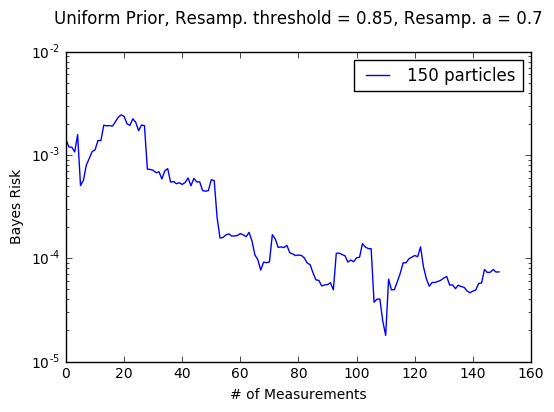

In [154]:
bayes_risk = track_loss.mean(axis=0)

plt.semilogy(bayes_risk, label='{} particles'.format(n_particles))

plt.title('Uniform Prior, Resamp. threshold = ' +str(resamp_t) + ', Resamp. a = ' +str(resamp_a)+ '\n')
plt.xlabel('# of Measurements')
plt.ylabel('Bayes Risk')
plt.legend()

filefigname = dire+labelize+"_Ntests_"+str(n_trials)+"_Trotter-"+str(trotterize)+"_2qubits(Hf_I-0.5)"+"_Nparts_"+str(n_particles)+"___"+str(timestamp)+".pdf"
filefigname = os.path.normpath(filefigname)

print('Picture saved in'+filefigname)

plt.show()

# Tests using perf_test_multiple

In [155]:
prior = distr.MultiVariateUniformDistribution(len(oplist), DistroLimits=np.array([[0.1,0.4]]))

# probelist can be either:
# - [probestate] : in this case the probe is constantly selected from the state provided
# - "eiglist" or "probelist": in this case, the probe is selected sequentially (eventually with some weighting) among the list provided

probecounter = 0
invertize=True
trotterize=True
model = gsi.GenSimQMD(oplist=oplist, modelparams=true_params, probecounter = probecounter,  
                      true_oplist = oplist, trueparams=true_params,
                      probelist=probelist, 
                      trotter = trotterize, IQLE=invertize)

n_particles = 150
n_experiments = 150

# higher resample_threshold -> higher frequency of resampling
# higher a in LiuWest -> less "data scrambling", slower learning

resamp_t = 0.85
resamp_a = 0.7
extra_updater_args={'resample_thresh': 0.7, 'resampler': qi.LiuWestResampler(a=0.8), 'debug_resampling': False}
updater = qi.SMCUpdater(model, n_particles, prior, **extra_updater_args)


#IQLE already works well with resample_thresh=0.5, resampler = qi.LiuWestResampler(a=0.8)

inv_field = [item[0] for item in model.expparams_dtype[1:] ]
print('Inversion fields are: ' + str(inv_field))
heuristic = mpgh.multiPGH(updater, oplist, inv_field=inv_field)
experiment = heuristic()
print('Heuristic output:' + repr(experiment))

expparams = np.empty((1, ), dtype=model.expparams_dtype)

print('Initialization Ready')

Inversion fields are: ['w_1', 'w_2', 'w_3']
Heuristic output:array([ (3.6012385338020594, 0.20447889782065246, 0.21596405293084953, 0.2559116505893788)], 
      dtype=[('t', '<f8'), ('w_1', '<f8'), ('w_2', '<f8'), ('w_3', '<f8')])
Initialization Ready


In [156]:
start = time.clock()

n_trials = 2
perf = qi.perf_test_multiple(model=model, n_trials = 2, n_particles=n_particles, prior=prior,
        n_exp=n_experiments, true_mps = true_params, heuristic_class=partial(mpgh.multiPGH, inv_field=inv_field, t_field='t'), 
                    extra_updater_args = extra_updater_args)

end=time.clock()
print('elapsed time: ' + str(end-start))

elapsed time: 19.355818348070898


Picture saved inC:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\tests_IQLE_Ntests_2_Trotter-True_2qubits(Hf_I-0.5)_Nparts_200____2017-07-25_10.41.17.pdf


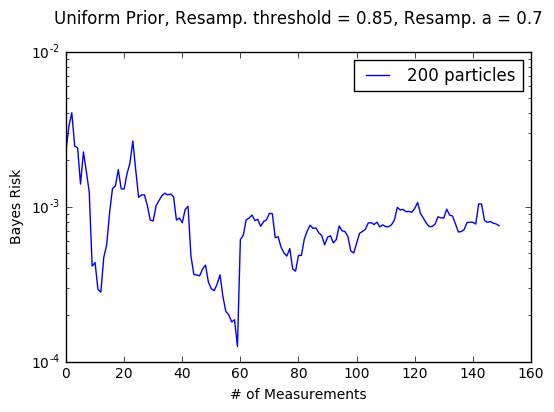

In [125]:
bayes_risk = perf['loss'].mean(axis=0)

plt.semilogy(bayes_risk, label='{} particles'.format(n_particles))

plt.title('Uniform Prior, Resamp. threshold = ' +str(resamp_t) + ', Resamp. a = ' +str(resamp_a)+ '\n')
plt.xlabel('# of Measurements')
plt.ylabel('Bayes Risk')
plt.legend()

filefigname = dire+labelize+"_Ntests_"+str(n_trials)+"_Trotter-"+str(trotterize)+"_2qubits(Hf_I-0.5)"+"_Nparts_"+str(n_particles)+"___"+str(timestamp)+".pdf"
filefigname = os.path.normpath(filefigname)

print('Picture saved in'+filefigname)

plt.show()